In [1]:
#Libraries for Model Visualization
from comet_ml import Experiment

In [2]:
experiment = Experiment(api_key="MHehhbanm9HbbvXptMjQ0hinn",
    project_name="tweet-sentiment-analysis",
    workspace="jessica-njuguna")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jessica-njuguna/tweet-sentiment-analysis/534d837c8301425098d0e0dff785e98b



# Climate Change Analysis Belief 2022
© Explore Data Science Academy

_Prepared by:_
- Jessica Njuguna
- Stanley Agbo
- Uchenna Unigwe
- Hunadi Mawela
- Teddy Waweru

## Introduction

Living things are dependent on particular conditions to survive. Humans are not exempt from this. Having the right temperature, sufficient water, clean air, and enough food are among the basic requirements for survival. The majority of these requirements depend on the stability of climate change. Climate change refers to shifts in the weather and temperature patterns. Human activity and natural occurrences contribute to climate change.

Since the 1800s, human cultures have been the main drivers of climate change. With increased deforestation, combustion of fossil fuels and increased livestock farming, the concentration of greenhouse gases has increased. These gases cause a greenhouse effect by trapping the sun's heat and escalating global warming.

Warmer temperatures change weather patterns disrupting the natural conditions of the earth. These disruptions harm our environment, degrading the quality of the Earth's air and water. In a bid to cool the earth and reduce the rate of climate change, global organizations are campaigning for more environmentally friendly products and practices. 

### Problem Statement

In the 21st Century, more companies build their brand with the consideration of **lessened environmental impact** or **carbon footprint**. Thus, their operations products and services are inclined to being more **environmentally friendly** and sustainable, in line with their values and ideals. <br>
To improve market research on their products/services, we developed the folowing **ML project** that intends to determine how people **perceive climate change**, and _whether or not they believe it is a real threat_. <br>

We believe this would provide a **metric** on how companies' products/service may be **received by the public**. Providing a robust ML solution will enable our clients to **access to a broad base of consumer sentiment**, spanning multiple demographic and geographic categories - thus **increasing their insights and informing future marketing strategies**.<br>

To build our **predictive model** for the project, we utilized a dataset of **collected tweet data** to determine if a person believes in climate data or _not_.


### Table of Contents

[Introduction](#introduction)
- Problem Statement
- Table of Contents
- Summary
    - Agenda
    - Deliverables
    - Results
    - Future Considerations
- Preliminary Activities
    - Importing Packages
    - Loading the Datasets
    
[Exploratory Data Analysis](#exploratory_data_analysis)
- Functions Declaration
- Statistical Summaries
    - Train Dataset
    - Test Dataset
- Visualizations

[Data Engineering](#data_engineering)
- Functions Declaration
- Dealing with Null Values
- Splitting features
- Dummy Variables
- Data Scaling
- Feature Selection

[Modelling](#modelling)
- Functions Declaration
- RandomForest Classification
    - Introduction #
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- XG Boost Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Hyper Parameter Tuning

[Model Performance Comparison](#model_performance_comparison)


[Model Explanation](#model_explanation)

[Conclusion](#conclusion)

[Appendix](#appendix)
- Kaggle Submission
    - Functions Declaration
    - Submission Metrics




    






### _Summary_

**Agenda:**

**Deliverables:**

**Results:**

**Future Considerations:**

### Preliminary Activities

#### Importing Packages

In [82]:
# Libraries for data loading, data manipulation
import pandas as pd
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
from wordcloud import WordCloud
from statsmodels.graphics.correlation import plot_corr
from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION

#Libraries to clean the text
import contractions #This expands contraction such as 'don't' to 'do not'
import regex as re
import string
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import emoji #allows us to manipulate with emojis
import itertools


#Libraries for test pre-processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer


# Libraries for data preparation
# import statsmodels.formula.api as sm
# from statsmodels.formula.api import ols
# from scipy.stats import pearsonr
# from statsmodels.distributions.empirical_distribution import ECDF       #Imported for displaying the Empirical Cumulative Distribution of Features
# from sklearn.feature_selection import SelectKBest, f_regression

# Libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor

#Libraries for Model Performance
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.tree import plot_tree
# from sklearn.model_selection import GridSearchCV

# Libraries for mathematical analyses
import numpy as np


#Library for creating pickle files of the models
import pickle

# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

<ipython-input-82-cd5b45878481>:11: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION


#### Loading the datasets

The project has two datasets:

1. The train data
    - This is the data that will be used to teach the Machine Learning Algorithm(model) to predict the sentiments.
2. The test data
    - The observations here will be predicted to gauge the prediction accuracy of the model(s) trained.

In [4]:
#load the datasets in raw_df
raw_train_df = pd.read_csv('resources/data/train.csv')
raw_test_df = pd.read_csv('resources/data/test.csv')

## Exploratory Data Analysis

Exploratory Data Analysis(EDA) refers to investigating the data in its raw form to spot anomalies, discover patterns and check for assumptions using summary statistics. 

Preliminary checks of the EDA might include:

1. Columns in the data
2. Number of observations in the data
3. Presence of missing values in the data
4. Presence of duplicates
5. Type of data in the columns; numerical(discrete, continuous), categorical or time
6. Presence of outliers/uncommon observations

The patterns existing in the dataset can be displayed using graphs and visuals. To outline the patterns, we look at:
- Patterns in the individual columns (univariate analysis)
- Patterns between columns (multivariate analysis)

Analysis of the patterns allows us to test hypotheses that can give us insight into the topic the data covers. Going through the EDA process is necessary because it highlights the steps for preparing the data for prediction modelling.

### Statistical Summaries

#A00

Statistical Summaries are used to communicate information about large datasets by summarizing the set of observations. 

They can be measures of central tendancy (mean, mode), distribution (skewness and kurtosis) and relationship (correlation). The features of the dataset in this project is expected to be text data. The summaries that will be covered in the EDA are mode. Mode refers to the most frequent object, in this case words. The anomalies covered are the null values and the duplicates.

#### Train Dataset

We have loaded two datasets: train and test. This section explores the train dataframe. Thereafter, we will explore the test dataframe

First, we make a copy of the train dataset. Any manipulations on the data frame does not have an effect on the raw train_df. 

In [57]:
#Set deep as True to copy both the indices and data of the df
train_df = raw_train_df.copy(deep = True)

Next, we view the first five columns of the dataset. This gives us an overview of the columns and a preview of the rows

In [7]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


From the first five rows we see that the train df contains three columns containing the tweet in the message column, the sentiment in numerical figures and the tweetid.

Sometimes, data is inappriately stored and can cause issues when performing analysis. Therefore, we check the data type of the columns using .info 

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The sentiment and tweetid column are stored as integers and the message is stored as string. These data types match the contents in the column. 

Given that the message is as string, we will have to convert it to numerical format in the feature engineering section. This will be done using vectorization. Vectorization takes the words in the columns and assigns them a numerical figure based on calculations on its frequency in the column.

Next, we inspect the number of observations in the dataframe. This allows us to see how many values we will be working with in the modelling phase.

In [9]:
train_df.shape

(15819, 3)

The dataset contains 15,819 observations. Observations above 30 are considered as best practice for modelling.

Now that we have general information about the dataset, we look at our target variable. 

The sentiments are our target variable, using value_counts we see the different categories of sentiments and their corresponding number of observations and visualize with a bar graph

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

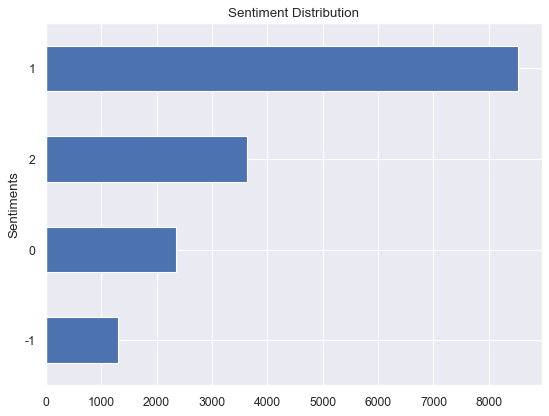

In [68]:
#set the figure size
plt.figure(figsize=(8,6), dpi=80)

#plot the frequency of the sentiments:
#using df.plot function
train_df['sentiment'].value_counts(ascending = True).plot(kind = 'barh', 
                                                          title = 'Sentiment Distribution', 
                                                          xlabel = 'Sentiments',
                                                         ylabel = 'Frequency')
#display the actual values of the sentiments
train_df['sentiment'].value_counts()

As seen above, the sentiment column has four unique integers. From our variable description, we derive the following meanings for each category:
- 2 News: the tweet links to factual news about climate change
- 1 Pro: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Anti: the tweet does not believe in man-made climate change

From the cell above, we see that Pro sentiments are the highest in the dataset with 8,530 observations. The Anti The sentiments are lowest with 1,296 obseravations. 

Therefore, our data has more information about Pro sentiments than it does about Anti sentiments. This is a representation gap that is reffered to as _imbalanced dataset_. Due to the insufficient information we have about the lower frequency sentiments,  the learning capability of our model is compromised.

In the feature engineering section, we will fix this by randomly selecting examples from the minority sentiments and adding them to the dataframe with replacement.


##### Duplicates

Incorrect duplicates affect the learning capability of the model. It is an anomally that gives conflicting information to the model. For this reason, we check for incorrect duplicates in the data to remove them in the Feature Engineering section. We are only concerned with the incorrect duplicates because we have a imbalanced dataset as highlighted above. The correct duplicates will remain in the dataset.

For this classification problem, each unique observation should have its own sentiment. That is, one tweet can not have two sentiments. Failure to which, the observation will be dropped.

We first check if there are duplicates in the tweet_id column using .unique()


In [11]:
#Inspecting the tweetid column
len(train_df['tweetid'].unique())

15819

The unique values of the tweetid column are equal to the number of observations in the dataset. Therefore, they are unique identifies to the tweets and there are no duplicate values.

We can now check if all the tweets are unique.

In [12]:
#Checking the number of unique values

len(train_df['message'].unique())

14229

There are 14,229 unique tweets which is less than the number of rows in the dataset. This is an indication of duplicated tweets in the dataset.

We get the exact number of duplicates in the message column by checking the shape of duplicated messages.

 1    1308
 0     109
 2      98
-1      75
Name: sentiment, dtype: int64


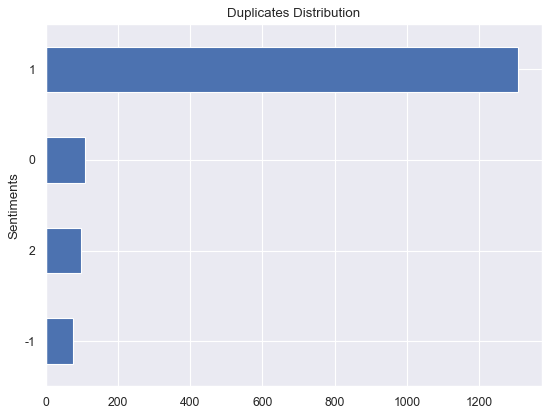

In [69]:
#create a dataframe of duplicates
dupli = train_df[train_df.duplicated(['message'])]

#set the size of the plot
plt.figure(figsize=(8,6), dpi=80)
#generate the horizontal bar graph:
#using df.plot
dupli['sentiment'].value_counts(ascending = True).plot(kind = 'barh', 
                                                       title = 'Duplicates Distribution', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency')
#display the frequency of the duplicates per sentiment
print(dupli['sentiment'].value_counts())

The Pro sentiments have the highest number of duplicates and also the highest number of observations in the dataset. To assist with imbalancing, the duplicates for the Pro sentiments in the Feature Engineering section.

The duplicated tweets are 1,590. This is quite a number.
We are only interested in the tweets are similar but have been classified opposing each other. We check this by grouping the tweets and counting the unique sentiments of the grouped tweet. If a tweet has more than one unique sentiment, we conclude that it is an incorrect duplicate

In [59]:
#filter the tweets: 
#that have more than one sentiment and create a df

duplicates = train_df.groupby('message').filter(lambda x: len(x['sentiment'].unique()) > 1)

#display the contents in the df
duplicates

,sentiment,message,tweetid
258,-1,RT @Uniocracy: They'll tell you theyre doing i...,529327
2390,2,RT @Channel4News: .@LeoDiCaprio calls on citiz...,460524
5393,0,RT @Uniocracy: They'll tell you theyre doing i...,723133
8446,0,RT @realDonaldTrump: Where the hell is global ...,228082
9141,0,RT @COP22: In 4 days the most ambitious climat...,407156
10351,1,RT @Channel4News: .@LeoDiCaprio calls on citiz...,93815
12001,-1,RT @realDonaldTrump: Where the hell is global ...,663534
14103,1,RT @COP22: In 4 days the most ambitious climat...,357058


Out of the duplicated observations, 8 of them are not equal in sentiment. These give us confilicting information about the relationship betweeen the tweet and the sentiment. 

Considering that the train dataset is imbalanced, we will drop the duplicates in the feature engineering section.

##### Missing data

Missing data refers to empty values in the data set. They are also referred to as null values and are represented as 'NaN'. Columns with alot of missing data can be dropped. The criteria of whether to drop a column with null values can be determined by a threshhold. If the column does not surpass a stipulated null value thresh hold, the null values can be replaced with the most frequent value in the column or the average of the column. 

We check for missing data by summing the number of null values for each column, as below.

In [16]:
train_df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

There are no null values in the dataset. Therefore, no imputation will be perfomed on the data set. With these checks done, we can step into our main feature, the tweets.

##### Tweet Visualization

In this segment, we step into the tweets. We take a sample and view what it contains. One way to do this is through wordclouds.
Wordclouds are graphical representations of word frequency. It gives priority to more frequent words, and displays them with different font sizes. More frequent words appear larger than the less frequent words.

Generating the word cloud, gives us insight to what is prominent in each sentiment represented. We will also view the anomolies in the tweets that will be cleaned in the Feature Engineering section.

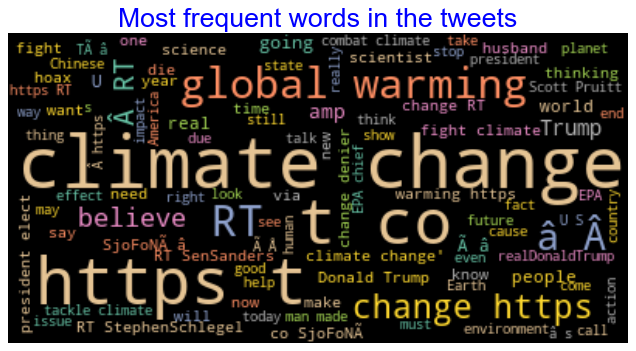

In [92]:
#generating the wordcloud to show the top 50 words
wordcloud = WordCloud(max_font_size=50, min_font_size = 6, background_color="black", 
                      colormap = 'Set2').generate(' '.join(train_df['message']))
#adjusting the size of the graph
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

#setting the title
plt.title('Most frequent words in the tweets', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

The wordcloud has generated the top 50 words in the message column. Climate change and global warming are the most frequent words judging by their size. This is in line with the project topic, especially that most tweets in the dataset are for pro-climate change sentiments. 

In addition we see some words that are not in English e.g.  SjoFoNá, and words that are not directly related to expressing a sentiment like 'RT'. This is referred to jargon. The process of eliminating the data in the tweets that is noise to the sentiment is called garbage in, garbage out. In the feature engineering section, we will perform this task before modelling the data.


Let us step into the tweets per sentiments and generate word clouds to check for patterns in the top 50 words

In [71]:
#We generate a new data frame that joins all the tweets per sentiment

train_grouped=train_df[['sentiment','message']].groupby('sentiment').agg(sum)
train_grouped.head()

,message
sentiment,
-1,Sally Kohn’s latest evidence of climate change...
0,Calum: *tweets abt reunitingish w the cast*\r\...
1,PolySciMajor EPA chief doesn't think carbon di...
2,RT @RawStory: Researchers say we have three ye...


The resulting dataframe has one columns with the concatened tweets and four rows with the sentiments. To ascertain our success, let us sample on of the rows.

In [19]:
#Viewing a row from the grouped dataframe

train_grouped['message'][2]

"RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…RT @tveitdal: We only have a 5 percent chance of avoiding ‘dangerous’ global warming, a study finds https://t.co/xUBTqNxhkK https://t.co/of…Fossil fuel giant ExxonMobil ‘misled’ the public about climate change, Harvard academics conclude https://t.co/ofc2WSu4EXBangladesh confronting climate change head on https://t.co/MTqeNBQDUt https://t.co/itgkUxgEfgRT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t…RT @Independent: Trump's team removed climate change data from the White House website. They may be breaking the law…2050 climate targets: nations are playing the long game in fighting global warming https://t.co/dnegw2vfJd via @ConversationEDURT @washingtonpost: The Alaskan tundra is filling the atmosphere with carbon dioxide, worsening climate change https://t.

The third row contains all the tweets of one sentiment. Success! With the grouped data we can now create the wordclouds per sentiment, beginning with the anti sentiments

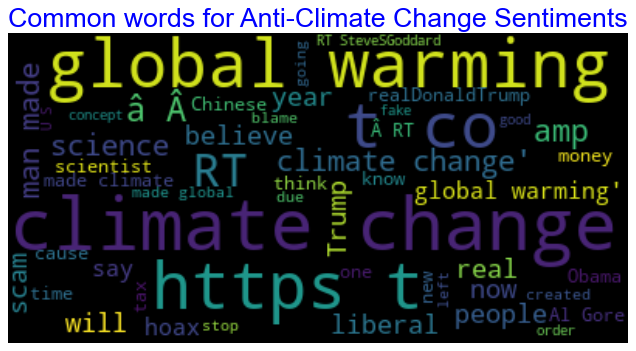

In [20]:
#select the tweet of the sentiment in index 0
text = train_grouped.iloc[0,0]
#generate the wordcloud with the 50 top words

wordcloud = WordCloud(max_font_size=50, min_font_size = 6, background_color="black", 
                      colormap = 'Set2').generate_from_text(text)

#set the figure size
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

#Set the title with font size 0f 24 and in color blue
plt.title('Common words for Anti-Climate Change Sentiments', 
          fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

The wordcloud shows that:
- Climate change and global warming are the most frequent words, similar to the general tweets wordcloud
- There is unnecessary jargon and common words e.g. cause and going
- Some key words in the wordcloud such as hoax and foax are grammarly aligned with anti-sentiments

Next, we visualize the Neutral Sentiments:

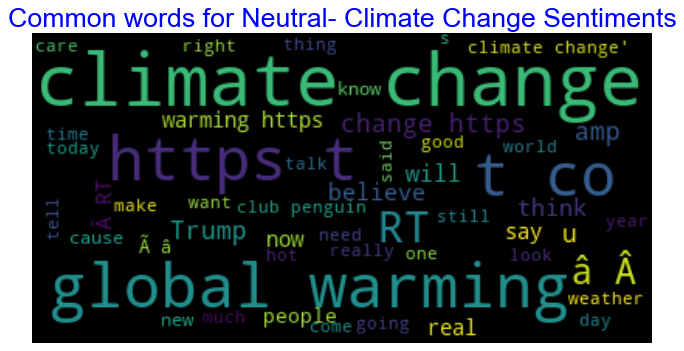

In [21]:
#select the tweet of the sentiment in index 1
text = train_grouped.iloc[1,0]
#generate the wordcloud with the 50 top words

wordcloud = WordCloud(max_font_size=50, min_font_size = 6, background_color="black", 
                      colormap = 'Set2').generate_from_text(text)

#set the figure size
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

#Set the title with font size 0f 24 and in color blue
plt.title('Common words for Neutral-Climate Change Sentiments', 
          fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

The wordcloud for the neutral sentiments shows that:
- Climate change and global warming are the most frequent words, similar to the general tweets wordcloud
- There is unnecessary jargon and common words e.g. will and u


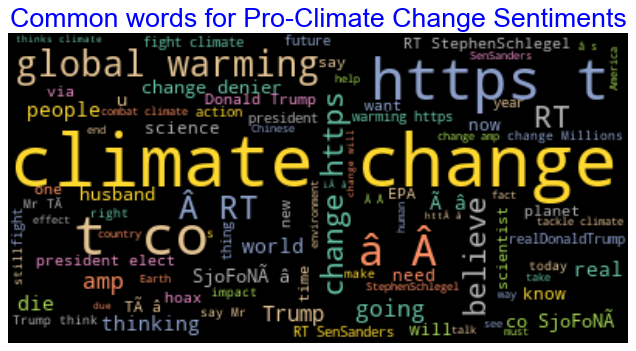

In [89]:
#select the tweet of the sentiment in index 2
text = train_grouped.iloc[2,0]
#generate the wordcloud with the 50 top words

wordcloud = WordCloud(max_font_size=50, min_font_size = 6, background_color="black", 
                      colormap = 'Set2').generate_from_text(text)

#set the figure size
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

#Set the title with font size 0f 24 and in color blue
plt.title('Common words for Pro-Climate Change Sentiments', 
          fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

The wordcloud for the pro sentiments shows that:
- Climate change and global warming are the most frequent words, similar to the general tweets wordcloud
- There is unnecessary jargon and common words e.g. https and SjoFoNá
- Some key words in the wordcloud such as believe and real are grammarly aligned with pro-sentiments

Finally, we visualize the factual sentiments

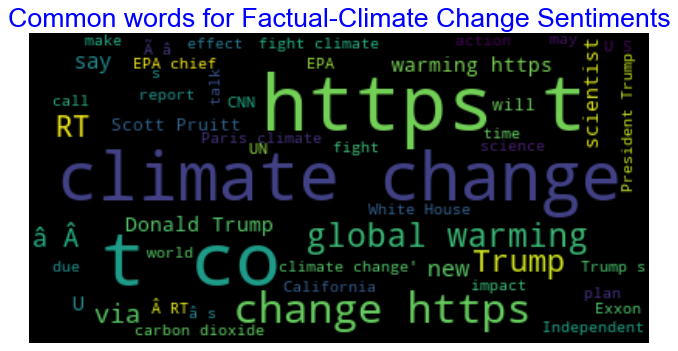

In [23]:
#select the tweet of the sentiment in index 3
text = train_grouped.iloc[3,0]
#generate the wordcloud with the 50 top words

wordcloud = WordCloud(max_font_size=50, min_font_size = 6, background_color="black", 
                      colormap = 'Set2').generate_from_text(text)

#set the figure size
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

#Set the title with font size 0f 24 and in color blue
plt.title('Common words for Factual-Climate Change Sentiments', 
          fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

The wordcloud for the factual sentiments shows that:
- Climate change and global warming are the most frequent words, similar to the general tweets wordcloud
- There is unnecessary jargon and common words e.g. rt and s
- Some key words in the wordcloud such as report and CNN are grammarly aligned with news. 


##### In summary:

- Our dataset contains 15,189 observations and three columns; tweet id, message and sentiment
- There are no missing values in the dataset
- There are duplicates that will be dropped in the Feature Engineering section
- The tweets contains jargon and words that are not necessary for gaining insights. Therefore, it will be cleaned.

In addition to this, there is potential to create more features about the tweet. For example the word length, the number of punctuations, etc. This will be covered in the Feature Extraction section. Using the new features, we will attempt to enhance our understanding of the relationship between the tweets and the sentiment.

Having extensively explored the train data set, let us proceed to do the same with the test data set.

#### Test Dataset

It is best practice to separate the data into train and test dataframe. The train dataframe will be used to teach our model while the test dataframe checks if the model predicts accurately. For this project the predictions made on the test dataframe will be submitted on the kaggle challenge.

Similar to the train dataset, we first create a copy of the dataset in accordance with best practices

In [24]:
test_df = raw_test_df.copy(deep = True)

We then proceed to view the first five rows in the dataset

In [25]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


The test dataframe has two columns with the message and tweetid. The target variable, sentiment is not present in the dataset.

The message column contains text while the tweet id contains numerical figures.

In [26]:
test_df.shape

(10546, 2)

The dataframe has 10,546 observations which we will use to predict for the model.

In [27]:
test_df.isna().sum()

message    0
tweetid    0
dtype: int64

There are no null values in the dataframe. Therefore, there is no need to drop any rows.

##### Checking for duplicates

In [28]:
len(raw_test_df['tweetid'].unique())

10546

The tweet id  has no duplicates and uniquely identifies each tweet in the dataframe. Next we check if each tweet is unique.

In [29]:
len(test_df['message'].unique())

9575

The message column has duplicates since the number of unique tweets is less than the total number of observations in the dataframe.

The code below allows us to get the exact number of duplicates using '.duplicated'.

In [30]:
test_df[test_df.duplicated(['message'])].shape

(971, 2)

In the test dataframe, we have 971 duplicate tweets. During the model prediction, we will test out if the model predicts the same sentiment for the duplicated tweets. This will help us view the accuracy of the model

##### Tweet Visualisation

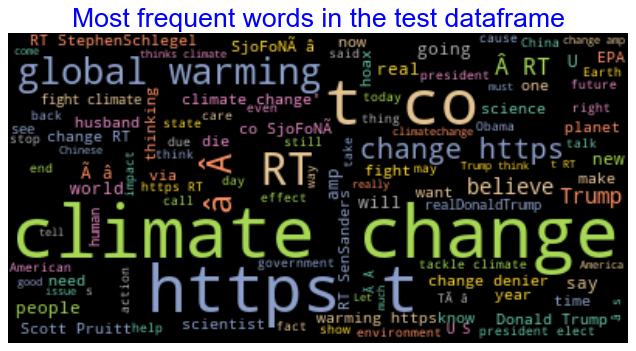

In [93]:
#generate the wordcloud
wordcloud = WordCloud(max_font_size=50, min_font_size = 6, background_color="black", 
                      colormap = 'Set2').generate(' '.join(test_df['message']))
#set the graph size
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
#set the title
plt.title('Most frequent words in the test dataframe', fontsize = 24, color = 'blue')
#set the axis as off
plt.axis("off")
#show the plot
plt.show()

From the wordcloud, we derive the following insights:

- Climate change, global warming are some of the most frequent words in line with our topic. 
- Presence of https shows that there are many urls
- There is jargon in the tweet, e.g. SjoFoNá
- There is a mix of pro and anti words in the columns, e.g. believe and hoax.

The noise in the data, we will cleaned through the same steps that will be done for the train dataframe. In addition, the features engineered will be applied to the test dataframe before feeding it into the model for predictions.

Now we can move on to the next section, Data Engineering.

## Data Engineering

### Functions Declaration

In [32]:
def expand_contractions(text):
    #takes the text
    expanded = contractions.fix(text)
    #returns expanded text
    return expanded

# Function to drop links from text using regex to replace the link with a comma
def strip_links(text):
    #define the regex formula to find urls
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    #finds all the links in the text
    links = re.findall(link_regex, text)
    #iterates over all the links
    for link in links:
        #replace the link with a comma
        text = text.replace(link[0], ', ')
        #retuns the text without links
    return text

# Function to drop mentions from text
def strip_mentions(text):
    #Twitter mentions start with '@', we create a list with that character
    strip_sign = ['@']
    
    #for separator in  string.punctuation:
        #if separator not in strip_sign :
            #text = text.replace(separator,' ')
    # we create an empty list
    words = []
    #Iterate over each word in the text
    for word in text.split():
        #remove all leading spaces and trailing spaces in the word
        word = word.strip()
        if word:
            #check if the first character of the word is not '@'
            if word[0] not in strip_sign:
                #if False it appends the word to the list words
                words.append(word)
    #returns the text as string with all mentions removed
    return ' '.join(words)

#Function to Lemmatize the words
'''
Lemmatization is the process of reducing a variation of a word to
it's root word. For example; cooking to cook or adventurous to adventure
'''
#Create a function lemmatizer from WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def tweet_lemma(text, lemmatizer):
    
    #iterates over each word in the text and lemmatizes it
    return [lemmatizer.lemmatize(t) for t in text]    

#Function to remove stop_words
def remove_stop_words(text):
    #iterates over each word in the text
    #appends only words that are not in the english stopwords list
    return [t for t in text if t not in stopwords.words('english')]

#Function to remove emojis
def remove_emojis(text):
    #iterates over each object in the text
    #appends the objects that are not in the emoji list
    return [t for t in text if t not in emoji.UNICODE_EMOJI]


tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
hashing_vectorizer = HashingVectorizer(n_features = 4000)
count_vectorizer = CountVectorizer()

#### Dropping duplicates

In the EDA section, it was noted that the Pro sentiments had the highest duplicates. In the following cell, we drop the duplicates of the Pro sentiments to improve the balance of the data.

In [33]:
train_df_allduplicate = train_df[(train_df['sentiment'] == 1 )& (train_df.duplicated(['message']))]
train_df_noduplicate = train_df_allduplicate.drop_duplicates('message', keep = 'first')
train_df_discduplicate = train_df_allduplicate.drop(index = train_df_noduplicate.index)
train_df = train_df.drop(index = train_df_discduplicate.index)
train_df_discduplicate.sort_values('message')

,sentiment,message,tweetid
9559,1,RT @1followernodad: parent: I'd do anything fo...,853233
11299,1,RT @1followernodad: parent: I'd do anything fo...,133976
12562,1,RT @1followernodad: parent: I'd do anything fo...,187199
15747,1,RT @1followernodad: parent: I'd do anything fo...,783223
11818,1,RT @1followernodad: parent: I'd do anything fo...,345949
...,...,...,...
7723,1,RT @savmontano: Our president doesn't believe ...,107394
5635,1,RT @savmontano: Our president doesn't believe ...,169280
10615,1,RT @voxdotcom: TrumpÃ¢â‚¬â„¢s election marks t...,396891
14128,1,RT @washingtonpost: 'Al Gore offers to work wi...,141082


In [34]:
dupli = train_df[train_df.duplicated(['message'])]
dupli['sentiment'].value_counts()
#dupli[dupli['sentiment'] == 1].sort_values(by = 'message')
#dupli[dupli['message'].str.contains('RT @AJEnglish')].sort_values(by = 'message')

 1    209
 0    109
 2     98
-1     75
Name: sentiment, dtype: int64

### Feature Extraction - In progress

Method features for additional features and look at how it distributes with each sentiment. Plot per class.(use box plot) describe

_1. Tweet Length_ 

This is also referred to as the number of characters in the string

In [35]:
train_df['tweet_len'] = train_df['message'].astype(str).apply(len)
train_df['tweet_len'].mean()

122.59191576086957

_2. Number of sentences_

In [36]:
tokeniser = TreebankWordTokenizer()
train_df['sent_count'] = train_df["message"].apply(lambda x: len(tokeniser.tokenize(x)))
train_df['sent_count'].mean()

22.1640625

_3. Number of words per tweet_ - Unigwe

In [37]:
train_df['word_count'] = train_df["message"].apply(lambda x: len(re.findall(r'\w+', x)))
train_df['word_count'].mean()

20.01032608695652

_4. Number of unique words per tweet_ - Hunadi

In [38]:
train_df['num_unique'] = train_df["message"].apply(lambda x: len(set(x.lower().split())))
train_df['num_unique'].mean()

16.903872282608695

_5. Number of stop words per tweet_ - Stanley

In [39]:
stop_words = set(stopwords.words('english'))
train_df['num_stop_words'] = train_df['message'].str.split().apply(lambda x: len(set(x) & stop_words))

In [40]:
train_df['num_stop_words'].mean()

4.070040760869565

_6. Number of punctuations per tweet_ - Stanley

In [41]:
train_df['num_punctuations'] = train_df["message"].apply(lambda x: len(re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', 
                        x)))
train_df['num_punctuations'].head()

0    137
1     63
2    137
3     98
4    123
Name: num_punctuations, dtype: int64

_7. Number of hashtags_

In [42]:
train_df['num_hashtags'] = train_df["message"].apply(lambda x: len(re.findall(r'(#w[A-Za-z0-9]*)', x)))
train_df['num_hashtags'].value_counts()

0    14681
1       38
2        1
Name: num_hashtags, dtype: int64

_8. Number of mentions_

In [43]:
train_df['num_mentions'] = train_df["message"].apply(lambda x: len(re.findall(r'(@w[A-Za-z0-9]*)', x)))
train_df['num_mentions'].value_counts()

0    14507
1      213
Name: num_mentions, dtype: int64

_9. Number of words in UpperCase_

In [44]:
train_df['num_uppercase'] = train_df["message"].apply(lambda x:sum(map(str.isupper,x.split())))
train_df['num_uppercase'].mean()

1.0319972826086956

### Cleaning the text data - Done, Markdowns left

Introductory paragraph

Unstructured data is about 90% in different formats, describe the formats. The extra features are called noise. 

To further explore the data, we will clean the text by performing the following steps:

1. Expand contractions
2. Remove digits and words containing digits
3. Lower the message
4. Remove punctuation
5. Lemmetazition
6. Vectorization

The cleaned tweets will be stored in a new column 'cleaned_message' to manage errors

_1. Expanding contractions_

In [45]:
train_df['message']=train_df['message'].apply(lambda x:expand_contractions(x))
train_df['message'][0:5]

0    PolySciMajor EPA chief does not think carbon d...
1    It is not like we lack evidence of anthropogen...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED : 2016 was a pivotal year...
4    RT @SoyNovioDeTodas: It is 2016, and a racist,...
Name: message, dtype: object

_2. Remove digits and words containing digits_

In [46]:
train_df['message']=train_df['message'].apply(lambda x: re.sub('\w*\d\w*','', x))
train_df['message'].head()

0    PolySciMajor EPA chief does not think carbon d...
1    It is not like we lack evidence of anthropogen...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED :  was a pivotal year in ...
4    RT @SoyNovioDeTodas: It is , and a racist, sex...
Name: message, dtype: object

_3. Lowercase all the tweets_

In [47]:
train_df['message']=train_df['message'].apply(lambda x: x.lower())
train_df['message'][0:5]

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired :  was a pivotal year in ...
4    rt @soynoviodetodas: it is , and a racist, sex...
Name: message, dtype: object

_4. Removing punctuation_

In [48]:
train_df['message']=train_df['message'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
train_df['message'][0:5]

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt rawstory researchers say we have three year...
3    todayinmaker wired   was a pivotal year in the...
4    rt soynoviodetodas it is  and a racist sexist ...
Name: message, dtype: object

_5. Lemmatization_

In [49]:
tokeniser = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmer(words):
    token_words = TreebankWordTokenizer().tokenize(words)
    lem_sentence=[]
    for word in token_words:
        #just lemmmatize
        #stem_word = snowball.stem(word)
        lem_word = lemmatizer.lemmatize(word)
        lem_sentence.append(lem_word)
        lem_sentence.append(" ")
    return "".join(lem_sentence)

train_df['message'] = train_df['message'].apply(lemmer) 
train_df['message'].head()


0    polyscimajor epa chief doe not think carbon di...
1    it is not like we lack evidence of anthropogen...
2    rt rawstory researcher say we have three year ...
3    todayinmaker wired wa a pivotal year in the wa...
4    rt soynoviodetodas it is and a racist sexist c...
Name: message, dtype: object

#### Splitting the Features and Labels

In [50]:
X = train_df.drop(columns = ['tweetid', 'sentiment'], axis = 1)
y = train_df['sentiment']
X.reset_index(drop = True, inplace = True)
print(list(X.columns))

['message', 'tweet_len', 'sent_count', 'word_count', 'num_unique', 'num_stop_words', 'num_punctuations', 'num_hashtags', 'num_mentions', 'num_uppercase']


#### Vectorizing the data set

In [51]:
text =train_df.message
# text
tfidf_vectorizer.fit(text)

tfidf_dense = tfidf_vectorizer.transform(X['message']).todense()
new_cols = tfidf_vectorizer.get_feature_names()
X = X.drop(columns = ['message'], axis = 1)
#tfidf_X_train_df = pd.DataFrame(tfidf_feat)
X = X.join(pd.DataFrame(tfidf_dense, columns = new_cols))
#columns = ['num_hashtags','num_punctuations','num_mentions','num_uppercase', 'num_unique']
converted_X = X.astype('float16')

#Vectorized_train = pd.merge(tfidf_X_train_df,X[columns],left_index=True, right_index=True)

print('TF-IDF Vector Shape: \t {}'.format(len(tfidf_vectorizer.get_feature_names_out())))


C:\Users\USER\SeraApps\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Vector Shape: 	 22981


In [53]:
X_train, X_test, y_train, y_test = train_test_split(converted_X, y,
                        test_size=0.3,
                        random_state=42)

#### Visualizing the Cleaned Text - In progress

Let's group the data by sentiment

In [ ]:
train_grouped=train_df[['sentiment','cleaned_message']].groupby('sentiment').agg(sum)

In [ ]:
train_grouped

### Feature Selection - In progress

### Balancing the Datasets

In [54]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 2)
# X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

Oversampling generates a Memory Error. Let us try undersampling instead

In [ ]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_train_bal, y_train_bal = nm.fit_resample(X_train, y_train)

## Modelling - Stanley

#### Function Declaration

In [55]:
def fit_eval_model(model,X_train, X_test):
    # fit the model
    model.fit(X_train, y_train)
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}' for v1 in group_percentages]
    labels = np.asarray(labels).reshape(4,4)
    # labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    # labels = np.asarray(labels).reshape(2,2)
    print(labels)
    print(group_percentages)
    print(cf_matrix)
    sns.heatmap(cf_matrix,
                annot = labels,
                cmap = 'Blues',fmt = '',
                xticklabels = categories,
                yticklabels = categories)
    # plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    # plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    # plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Bernoulli Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      0.02      0.03       350
           0       0.85      0.13      0.23       725
           1       0.60      0.96      0.74      2255
           2       0.82      0.52      0.64      1086

    accuracy                           0.64      4416
   macro avg       0.82      0.41      0.41      4416
weighted avg       0.73      0.64      0.57      4416

[['0.14%' '0.20%' '7.34%' '0.25%']
 ['0.00%' '2.17%' '13.54%' '0.70%']
 ['0.00%' '0.18%' '49.03%' '1.86%']
 ['0.00%' '0.00%' '11.71%' '12.88%']]
['0.14%', '0.20%', '7.34%', '0.25%', '0.00%', '2.17%', '13.54%', '0.70%', '0.00%', '0.18%', '49.03%', '1.86%', '0.00%', '0.00%', '11.71%', '12.88%']
[[   6    9  324   11]
 [   0   96  598   31]
 [   0    8 2165   82]
 [   0    0  517  569]]


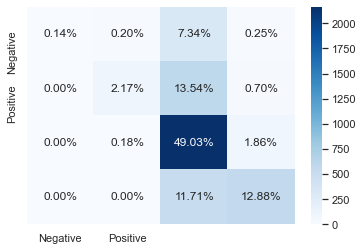

In [56]:
BNBModel = BernoulliNB()
fit_eval_model(BNBModel, X_train, X_test)

In [ ]:
BNB_comet = BernoulliNB()
BNB_comet.fit(tfidf_X_train,y_train)
y_pred = BNB_comet.predict(tfidf_X_test)

In [ ]:
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted', zero_division = 1)
recall = recall_score(y_test, y_pred, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion

In [ ]:
params = {"test_size": 0.3,
          "model_type": "Bernoulli-Naive_Bayes",
          "vectorizer": "tfidf vectorizer",
          "param_grid": "None" ,
          "stratify": True
          }
metrics = {"f1 score": f1,
           "recall matrix": recall,
           "precision matrix": precision,
           'confusion matrix': confusion
           }

In [ ]:
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### XG Boost Classification

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### Hyper Parameter Tuning

## Model Performance Comparison

### Functions Declaration

## Model Explanation

## Conclusion

## Appendix

### Kaggle Submission

#### Functions Declaration

In [124]:
#feed in preprocessing
#def preprocessing(df):
    return df

# def predict_model(model, df):
#    transforms to a df     
#     return predictions


In [62]:
test_df['tweet_len'] = test_df['message'].astype(str).apply(len)
test_df['sent_count'] = test_df["message"].apply(lambda x: len(tokeniser.tokenize(x)))
test_df['word_count'] = test_df["message"].apply(lambda x: len(re.findall(r'\w+', x)))
test_df['num_unique'] = test_df["message"].apply(lambda x: len(set(x.lower().split())))
test_df['num_stop_words'] = test_df['message'].str.split().apply(lambda x: len(set(x) & stop_words))
test_df['num_punctuations'] = test_df["message"].apply(lambda x: len(re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', 
                        x)))
test_df['num_hashtags'] = test_df["message"].apply(lambda x: len(re.findall(r'(#w[A-Za-z0-9]*)', x)))
test_df['num_mentions'] = test_df["message"].apply(lambda x: len(re.findall(r'(@w[A-Za-z0-9]*)', x)))
test_df['num_uppercase'] = test_df["message"].apply(lambda x:sum(map(str.isupper,x.split())))
test_df['message']=test_df['message'].apply(lambda x: re.sub('\w*\d\w*','', x))
test_df['message']=test_df['message'].apply(lambda x:expand_contractions(x))
test_df['message']=test_df['message'].apply(lambda x: x.lower())
test_df['message']=test_df['message'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
test_df['message'] = test_df['message'].apply(lemmer) 
test_tweets = test_df['message']
tfidf_testdense = tfidf_vectorizer.transform(test_tweets).todense()
test_df = test_df.drop(columns = ['message'], axis = 1)
test_df = test_df.join(pd.DataFrame(tfidf_testdense, columns = new_cols))
converted_test_df = test_df.astype('float16')

ValueError: could not convert string to float: 'Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq'

In [84]:
test_pred = BNBModel.predict(tfidf_X_test)

#### Submission Metrics

In [ ]:
#feed in model

#def submission(model, df)

In [85]:
###
sub_id = test_df['tweetid'].to_list()
sub_pred = test_pred.tolist()
list_of_tuples = list(zip(sub_id, sub_pred))
submission_df = pd.DataFrame(list_of_tuples,
                  columns = ['tweetid', 'sentiment'])
submission_df.set_index('tweetid', inplace=True)

In [86]:
submission_df['sentiment'].value_counts()

 1    5336
 2    2888
 0    1571
-1     751
Name: sentiment, dtype: int64

submission_df.to_csv('280322_Cleaned_Vectorizer_Submission.csv') #score of 0.700

submission_df.to_csv('290322_Lemmatized_stemmd_Vectorizer_Submission.csv') #score of 0.68